## Problem

A retail company “ABC Private Limited” wants to understand the customer purchase behaviour (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month.

The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month.

Now, they want to build a model to predict the purchase amount of customer against various products which will help them to create personalized offer for customers against different products.

## Column Labels

- User_ID: User ID
- Product_ID: Product ID
- Gender: Sex of User
- Age: Age in bins
- Occupation:	Occupation (Masked)
- City_Category:	Category of the City (A,B,C)
- Stay_In_Current_City_Years:	Number of years stay in current city
- Marital_Status:	Marital Status
- Product_Category_1:	Product Category (Masked)
- Product_Category_2:	Product may belongs to other category also (Masked)
- Product_Category_3:	Product may belongs to other category also (Masked)
- Purchase: Purchase Amount (Target Variable)

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import skew

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline

In [2]:
train = pd.read_csv('purchase_train.csv') 
test = pd.read_csv('purchase_test.csv')

In [3]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [4]:
# Getting some grasp on how much customers purchase products on average
train.Purchase.mean()

9263.968712959126

## Filling in missing values

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


We can see from above that "Product_Category_2" and "Product_Category_3" have missing values 

In [6]:
print(train.Product_Category_1.value_counts())
len(train.Product_Category_1.value_counts())

5     150933
1     140378
8     113925
11     24287
2      23864
6      20466
3      20213
4      11753
16      9828
15      6290
13      5549
10      5125
12      3947
7       3721
18      3125
20      2550
19      1603
14      1523
17       578
9        410
Name: Product_Category_1, dtype: int64


20

From category 1, we know that there are 20 product categories in total

In [7]:
train.Product_Category_2.value_counts()

8.0     64088
14.0    55108
2.0     49217
16.0    43255
15.0    37855
5.0     26235
4.0     25677
6.0     16466
11.0    14134
17.0    13320
13.0    10531
9.0      5693
12.0     5528
10.0     3043
3.0      2884
18.0     2770
7.0       626
Name: Product_Category_2, dtype: int64

In [8]:
# Same products are in the same category. Using this fact, we can fill in null values in the Product_Category_2 & 3 column.

train['Product_Category_2']=\
train.groupby(['Product_ID'])['Product_Category_2'].ffill().bfill()

train['Product_Category_3']=\
train.groupby(['Product_ID'])['Product_Category_3'].ffill().bfill()

I will view the three categories as one combined category. For example, a product in category 3,6 and 12 will be considered to be in combined category (3,6,12). Another product which is just in category 5 will be labeled as (5,0,0). Thus, we need to fill the NaNs in the Product_Category_2 and Product_Category_3 columns with "0".

In [9]:
train.fillna(0, inplace=True)

In [10]:
# No more missing values :D
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            550068 non-null float64
Product_Category_3            550068 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


## Making three product category columns into one

In [11]:
# train.set_index(['User_ID','Product_ID'], inplace=True)

In [12]:
# train_prod_cat2 = train.loc[:,['Gender','Age','Occupation','City_Category','Stay_In_Current_City_Years',
#                                'Marital_Status','Product_Category_2','Purchase']]

# train_prod_cat3 = train.loc[:,['Gender','Age','Occupation','City_Category','Stay_In_Current_City_Years',
#                                'Marital_Status','Product_Category_3','Purchase']]

In [13]:
# train_prod_cat2.columns = ['Gender','Age','Occupation','City_Category','Stay_In_Current_City_Years',
#                                'Marital_Status','Product_Category_1','Purchase']
# train_prod_cat3.columns = ['Gender','Age','Occupation','City_Category','Stay_In_Current_City_Years',
#                                'Marital_Status','Product_Category_1','Purchase']

In [14]:
# train = train.append(train_prod_cat2)
# train = train.append(train_prod_cat3)

In [15]:
# train.drop(labels=['Product_Category_2', 'Product_Category_3'], axis=1, inplace=True)

In [16]:
# train.dropna(inplace=True)

In [17]:
# # No missing values anymore :D
# train.info()

## Checking whether each Feature's representation is in good shape

### 'Age' Feature

In [18]:
train['Age'].value_counts()

26-35    219587
36-45    110013
18-25     99660
46-50     45701
51-55     38501
55+       21504
0-17      15102
Name: Age, dtype: int64

In [19]:
# replace age bins to approximate mean age of each bin for better feature representation

train['Age'] = train['Age'].replace({'26-35':30, '36-45':40, '18-25':21,
                                         '46-50':48, '51-55':53, '55+':55, '0-17':10})

In [20]:
train['Age'].value_counts()

30    219587
40    110013
21     99660
48     45701
53     38501
55     21504
10     15102
Name: Age, dtype: int64

### 'City_Category' Feature

In [21]:
# no problem
train['City_Category'].value_counts()

B    231173
C    171175
A    147720
Name: City_Category, dtype: int64

### 'Gender' Feature

In [22]:
# no problem
train['Gender'].value_counts()

M    414259
F    135809
Name: Gender, dtype: int64

### 'Marital_Status' Feature

In [23]:
# no problem
train['Marital_Status'].value_counts()

0    324731
1    225337
Name: Marital_Status, dtype: int64

### 'Occupation' Feature

In [24]:
# no problem
print(train['Occupation'].value_counts())
print(len(train['Occupation'].value_counts()))

4     72308
0     69638
7     59133
1     47426
17    40043
20    33562
12    31179
14    27309
2     26588
16    25371
6     20355
3     17650
10    12930
5     12177
15    12165
11    11586
19     8461
13     7728
18     6622
9      6291
8      1546
Name: Occupation, dtype: int64
21


### 'Stay_In_Current_City_Years' Feature

In [25]:
print(train['Stay_In_Current_City_Years'].value_counts())
print(len(train['Stay_In_Current_City_Years'].value_counts()))

1     193821
2     101838
3      95285
4+     84726
0      74398
Name: Stay_In_Current_City_Years, dtype: int64
5


In [26]:
train['Stay_In_Current_City_Years'] = train['Stay_In_Current_City_Years'].replace({'4+':4})

In [27]:
train['Stay_In_Current_City_Years'].value_counts()

1    193821
2    101838
3     95285
4     84726
0     74398
Name: Stay_In_Current_City_Years, dtype: int64

## Exploration through correlation and visualization

### Correlation

In [28]:
# No real numerical features
# No feature with strong correlation with target(purchase amount) 
corrmat = train.corr()

corrmat

,User_ID,Age,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
User_ID,1.000000,0.039459,-0.023971,0.020443,0.003825,0.001729,0.004297,0.004716
Age,0.039459,1.000000,0.092327,0.318062,0.060180,0.047336,0.037816,0.016328
Occupation,-0.023971,0.092327,1.000000,0.024280,-0.007618,-0.001512,0.006947,0.020833
Marital_Status,0.020443,0.318062,0.024280,1.000000,0.019888,0.013593,0.012185,-0.000463
Product_Category_1,0.003825,0.060180,-0.007618,0.019888,1.000000,0.284527,-0.020683,-0.343703
Product_Category_2,0.001729,0.047336,-0.001512,0.013593,0.284527,1.000000,0.262611,-0.127406
Product_Category_3,0.004297,0.037816,0.006947,0.012185,-0.020683,0.262611,1.000000,0.038499
Purchase,0.004716,0.016328,0.020833,-0.000463,-0.343703,-0.127406,0.038499,1.000000


### Visualization

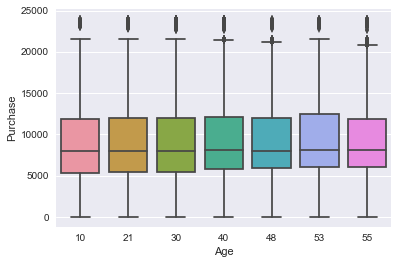

In [29]:
sns.boxplot(x = 'Age', y = 'Purchase',  data = train)

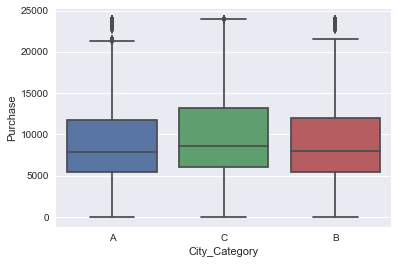

In [30]:
sns.boxplot(x = 'City_Category', y = 'Purchase',  data = train)

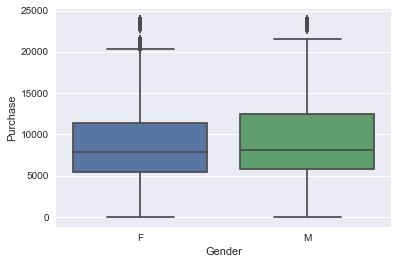

In [31]:
sns.boxplot(x = 'Gender', y = 'Purchase',  data = train)

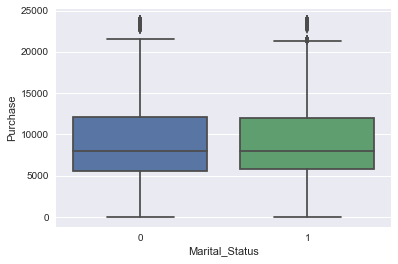

In [32]:
sns.boxplot(x = 'Marital_Status', y = 'Purchase',  data = train)

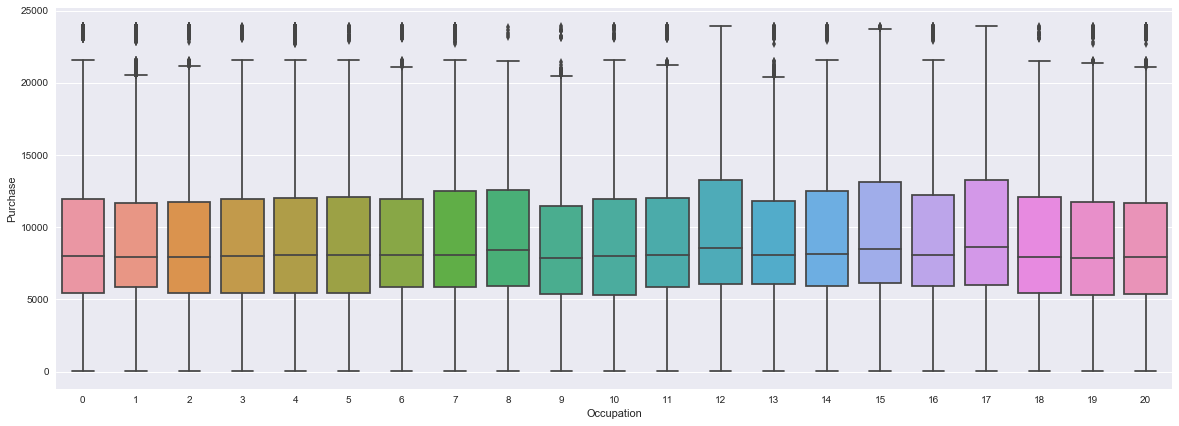

In [33]:
plt.figure(figsize=(20,7))
sns.boxplot(x = 'Occupation', y = 'Purchase',  data = train)

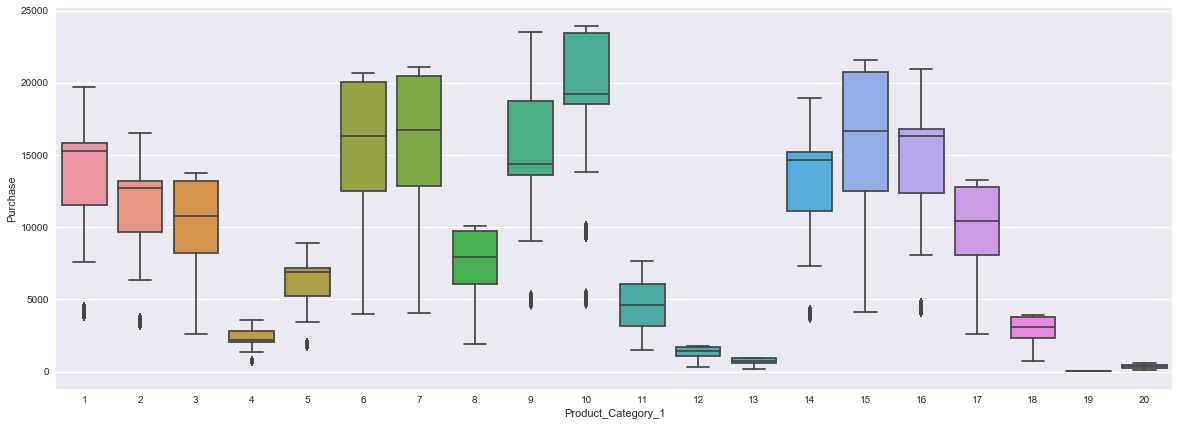

In [34]:
plt.figure(figsize=(20,7))
sns.boxplot(x = 'Product_Category_1', y = 'Purchase',  data = train)

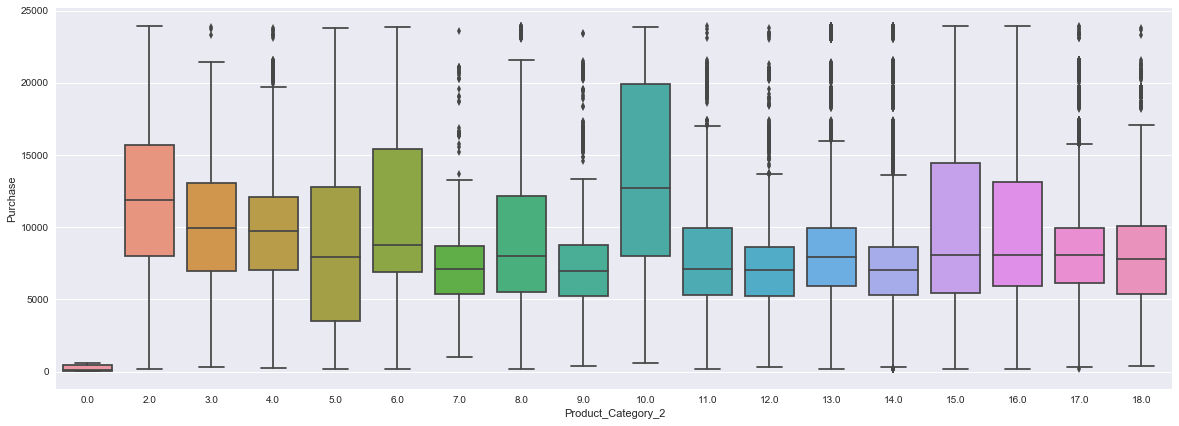

In [35]:
plt.figure(figsize=(20,7))
sns.boxplot(x = 'Product_Category_2', y = 'Purchase',  data = train)

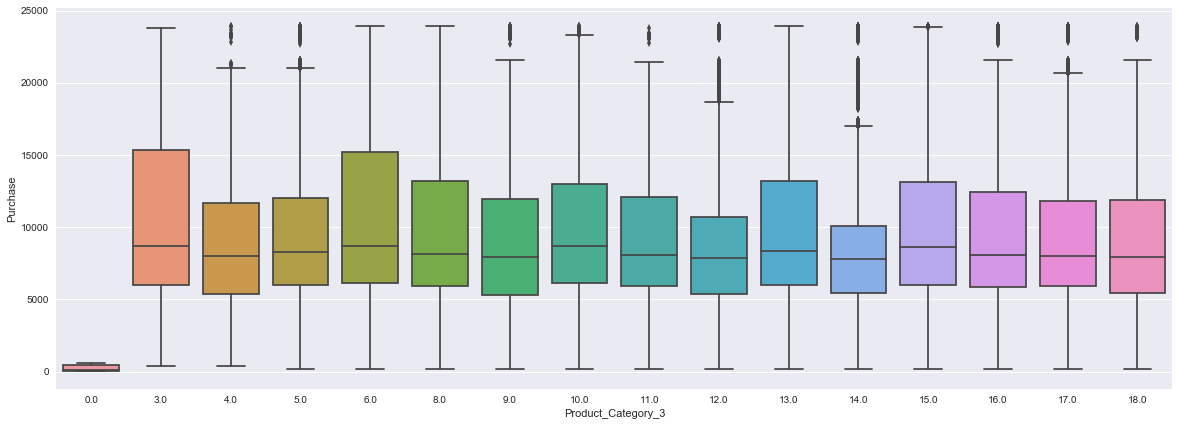

In [36]:
plt.figure(figsize=(20,7))
sns.boxplot(x = 'Product_Category_3', y = 'Purchase',  data = train)

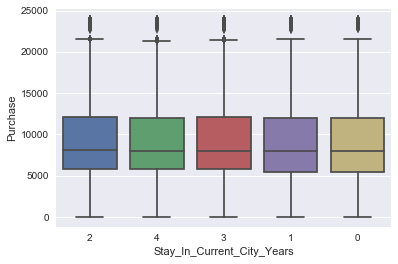

In [37]:
sns.boxplot(x = 'Stay_In_Current_City_Years', y = 'Purchase',  data = train)

The only feature that seems to have big differences in purchase amounts between different subsets of the feature is "Product_Category"

## Creating New Features

In [38]:
# changing float or integer values in product category 1 & 2 & 3 into string so that I can combine three columns into one combined category

train['Product_Category_1'] = train['Product_Category_1'].astype('str')
train['Product_Category_2'] = train['Product_Category_2'].astype('str')
train['Product_Category_3'] = train['Product_Category_3'].astype('str')

In [39]:
train['Product_Category_Combined']=\
train['Product_Category_1'] + '_' + train['Product_Category_2'] + '_' + train['Product_Category_3']

In [40]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Product_Category_Combined
0,1000001,P00069042,F,10,10,A,2,0,3,6.0,14.0,8370,3_6.0_14.0
1,1000001,P00248942,F,10,10,A,2,0,1,6.0,14.0,15200,1_6.0_14.0
2,1000001,P00087842,F,10,10,A,2,0,12,14.0,17.0,1422,12_14.0_17.0
3,1000001,P00085442,F,10,10,A,2,0,12,14.0,17.0,1057,12_14.0_17.0
4,1000002,P00285442,M,55,16,C,4,0,8,2.0,17.0,7969,8_2.0_17.0


## Encoding some categorical Features

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 13 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null int64
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null object
Product_Category_2            550068 non-null object
Product_Category_3            550068 non-null object
Purchase                      550068 non-null int64
Product_Category_Combined     550068 non-null object
dtypes: int64(5), object(8)
memory usage: 54.6+ MB


In [42]:
train.set_index(['User_ID', 'Product_ID'], inplace=True)

'Age' and 'Stay_In_Current_City_Years' are nominal features but they were already numbered from the beginning. But dtype of 'Stay_In_Current_City_Years' is object, so we need to change the dtype to float64 or int64

In [43]:
train.loc[:,'Stay_In_Current_City_Years'] = train.loc[:,'Stay_In_Current_City_Years'].astype('int64')

Marital Status feature is, strictly speaking, a nominal categorical feature. So, in order to use get_dummies on the feature, we need to change the dtype to string

In [44]:
train.loc[:,'Marital_Status'] = train.loc[:,'Marital_Status'].astype('str')

Since "Product_Category" is the only feature that has relatively strong correlation with the target, I will give different weights to each category in accordance with their respective mean values using the groupby method

In [45]:
train['Product_Category_Combined_num'] = train.groupby('Product_Category_Combined')['Purchase'].transform(lambda x: x.mean())

In [46]:
train['Product_Category_cat1_num'] = train.groupby('Product_Category_1')['Purchase'].transform(lambda x: np.median(x))

In [47]:
train = pd.get_dummies(train, columns=['City_Category', 'Gender', 'Occupation', 'Marital_Status'])

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 550068 entries, (1000001, P00069042) to (1006039, P00371644)
Data columns (total 37 columns):
Age                              550068 non-null int64
Stay_In_Current_City_Years       550068 non-null int64
Product_Category_1               550068 non-null object
Product_Category_2               550068 non-null object
Product_Category_3               550068 non-null object
Purchase                         550068 non-null int64
Product_Category_Combined        550068 non-null object
Product_Category_Combined_num    550068 non-null float64
Product_Category_cat1_num        550068 non-null float64
City_Category_A                  550068 non-null uint8
City_Category_B                  550068 non-null uint8
City_Category_C                  550068 non-null uint8
Gender_F                         550068 non-null uint8
Gender_M                         550068 non-null uint8
Occupation_0                     550068 non-null uint8
Occupation_1           

## Creating Additional New Features

In [49]:
train['Product_Category_Combined_num_2'] = (train['Product_Category_Combined_num'])**2
train['Product_Category_Combined_num_3'] = (train['Product_Category_Combined_num'])**3
train['Product_Category_Combined_num_sqrt'] = np.sqrt(train['Product_Category_Combined_num'])
train['Product_Category_cat1_num_2'] = (train['Product_Category_cat1_num'])**2

## Checking Skewness of nominal features and target label

We don't have any numerical features here, but I made one by giving different weights to different product categories. I will also examine the distribution of the target label(Purchase amount).

In [50]:
# Measuring Skewness of features
numerical_features = ['Product_Category_Combined_num', 'Product_Category_Combined_num_2',
                      'Product_Category_Combined_num_3','Product_Category_Combined_num_sqrt',
                     'Product_Category_cat1_num', 'Product_Category_cat1_num_2']

train[numerical_features].apply(lambda x: skew(x))

Product_Category_Combined_num         0.277748
Product_Category_Combined_num_2       0.923509
Product_Category_Combined_num_3       1.576666
Product_Category_Combined_num_sqrt   -0.458878
Product_Category_cat1_num             0.114017
Product_Category_cat1_num_2           0.535283
dtype: float64

In [51]:
# sqrt transformation to fix skewness

train.loc[:, ['Product_Category_Combined_num_2','Product_Category_Combined_num_3', 'Product_Category_cat1_num_2']] =\
np.sqrt(train.loc[:, ['Product_Category_Combined_num_2','Product_Category_Combined_num_3','Product_Category_cat1_num_2']])

In [52]:
# checking skewness again

train[numerical_features].apply(lambda x: skew(x))

Product_Category_Combined_num         0.277748
Product_Category_Combined_num_2       0.277748
Product_Category_Combined_num_3       0.640922
Product_Category_Combined_num_sqrt   -0.458878
Product_Category_cat1_num             0.114017
Product_Category_cat1_num_2           0.114017
dtype: float64

In [53]:
# Measuring skewness of target label (purchase amount)
skew(train['Purchase'])

0.6001383671643447

In [54]:
train.loc[:,['Purchase']]= np.sqrt(train.loc[:,['Purchase']])

In [55]:
# Measuring skewness of target label again
skew(train['Purchase'])

-0.13958758205102084

## Splitting into Training and Testing Data

In [56]:
train.columns.values

array(['Age', 'Stay_In_Current_City_Years', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase',
       'Product_Category_Combined', 'Product_Category_Combined_num',
       'Product_Category_cat1_num', 'City_Category_A', 'City_Category_B',
       'City_Category_C', 'Gender_F', 'Gender_M', 'Occupation_0',
       'Occupation_1', 'Occupation_2', 'Occupation_3', 'Occupation_4',
       'Occupation_5', 'Occupation_6', 'Occupation_7', 'Occupation_8',
       'Occupation_9', 'Occupation_10', 'Occupation_11', 'Occupation_12',
       'Occupation_13', 'Occupation_14', 'Occupation_15', 'Occupation_16',
       'Occupation_17', 'Occupation_18', 'Occupation_19', 'Occupation_20',
       'Marital_Status_0', 'Marital_Status_1',
       'Product_Category_Combined_num_2',
       'Product_Category_Combined_num_3',
       'Product_Category_Combined_num_sqrt', 'Product_Category_cat1_num_2'], dtype=object)

In [57]:
train.reset_index(inplace=True)

In [58]:
train.set_index(['User_ID', 'Product_ID','Product_Category_Combined'], inplace=True)

In [59]:
cat_dropped_train = train.drop(labels=['Product_Category_1', 'Product_Category_2', 'Product_Category_3'],axis=1)

In [60]:
cat_dropped_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 550068 entries, (1000001, P00069042, 3_6.0_14.0) to (1006039, P00371644, 20_0.0_0.0)
Data columns (total 37 columns):
Age                                   550068 non-null int64
Stay_In_Current_City_Years            550068 non-null int64
Purchase                              550068 non-null float64
Product_Category_Combined_num         550068 non-null float64
Product_Category_cat1_num             550068 non-null float64
City_Category_A                       550068 non-null uint8
City_Category_B                       550068 non-null uint8
City_Category_C                       550068 non-null uint8
Gender_F                              550068 non-null uint8
Gender_M                              550068 non-null uint8
Occupation_0                          550068 non-null uint8
Occupation_1                          550068 non-null uint8
Occupation_2                          550068 non-null uint8
Occupation_3                          550068 n

In [61]:
Y = cat_dropped_train.loc[:,['Purchase']]

In [62]:
X = cat_dropped_train.drop(labels=['Purchase'], axis=1)

In [63]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3, random_state=42)

In [64]:
print("X_train : " + str(type(X_train)) + str(X_train.shape))
print("X_test : " + str(type(X_test)) + str(X_test.shape))
print("Y_train : " + str(type(Y_train)) + str(Y_train.shape))
print("Y_test : " + str(type(Y_test)) + str(Y_test.shape))

X_train : <class 'pandas.core.frame.DataFrame'>(385047, 36)
X_test : <class 'pandas.core.frame.DataFrame'>(165021, 36)
Y_train : <class 'pandas.core.frame.DataFrame'>(385047, 1)
Y_test : <class 'pandas.core.frame.DataFrame'>(165021, 1)


In [65]:
# X_train = np.memmap('x_train.csv', dtype='float64', mode='w+', shape=(1148530,49))
# X_test = np.memmap('x_test.csv', dtype='float64', mode='w+', shape=(492228,49))
# Y_train = np.memmap('y_train.csv', dtype='float64', mode='w+', shape=(1148530,1))
# Y_test  = np.memmap('t_test.csv', dtype='float64', mode='w+', shape=(492228,1))

## Standardizing Numerical Features

In [66]:
# Standardize train data's numerical features

stdSc = StandardScaler()

X_train.loc[:,numerical_features] = stdSc.fit_transform(X_train.loc[:,numerical_features])
X_test.loc[:,numerical_features] = stdSc.fit_transform(X_test.loc[:,numerical_features])

C:\Users\Seungjun\Anaconda3\lib\site-packages\ipykernel\kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
C:\Users\Seungjun\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Making Score Metric

In [67]:
# Define error measure for official scoring : RMSE

scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= (np.sqrt(-cross_val_score(model, X_train, Y_train, scoring = scorer))).mean()
    return(rmse)

def rmse_cv_test(model):
    rmse= (np.sqrt(-cross_val_score(model, X_test, Y_test, scoring = scorer))).mean()
    return(rmse)

## Linear Regression

In [68]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr_model))
print("RMSE on Test set :", rmse_cv_test(lr_model))

RMSE on Training set : 15.3987882412
RMSE on Test set : 15.5354291081


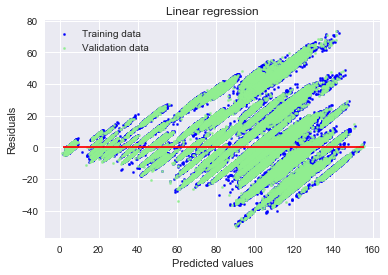

In [69]:
# Plot residuals
plt.scatter(lr_model.predict(X_train), lr_model.predict(X_train) - Y_train, c = "blue", label = "Training data", s=5)
plt.scatter(lr_model.predict(X_test), lr_model.predict(X_test) - Y_test, c = "lightgreen", label = "Validation data", s=5)

plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = min(lr_model.predict(X_train)), xmax = max(lr_model.predict(X_train)), color = "red")

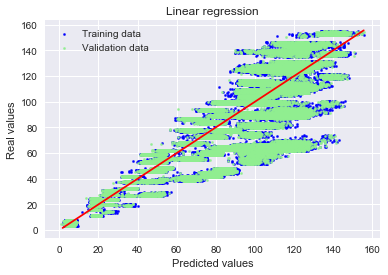

In [70]:
# Plot predictions
plt.scatter(lr_model.predict(X_train), Y_train, c = "blue", label = "Training data", s=5)
plt.scatter(lr_model.predict(X_test), Y_test, c = "lightgreen", label = "Validation data", s=5)

plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")

plt.plot([min(lr_model.predict(X_train)), max(lr_model.predict(X_train))], 
         [min(lr_model.predict(X_train)), max(lr_model.predict(X_train))], c='red')

## SGD Regressor

In [71]:
from sklearn.linear_model import SGDRegressor

In [72]:
sgd = SGDRegressor(random_state=42)
sgd.partial_fit(X_train, Y_train)

print("RMSE on Training set :", rmse_cv_train(sgd))
print("RMSE on Test set :", rmse_cv_test(sgd))

C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

RMSE on Training set : 43393209.4999


C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE on Test set : 81088461.1061


## Passive Aggressive Regressor

In [73]:
from sklearn.linear_model import PassiveAggressiveRegressor

In [74]:
pass_agg = PassiveAggressiveRegressor(random_state=42)
pass_agg.partial_fit(X_train, Y_train)

print("RMSE on Training set :", rmse_cv_train(pass_agg))
print("RMSE on Test set :", rmse_cv_test(pass_agg))

C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

RMSE on Training set : 22.9582293244


C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE on Test set : 25.956219088


## Ridge Regression

In [75]:
# X_train.values.shape, Y_train.values.shape

In [76]:
# ridge = RidgeCV(alphas = [0.01, 0.05, 0.1, 0.3, 0.6, 1, 3, 5, 10, 30, 60, 100], cv=10)

# ridge.fit(X_train[:5000], Y_train[:5000])
# alpha = ridge.alpha_
# print("Best alpha :", alpha)

# print("Ridge RMSE on Training set :", rmse_cv_train(ridge))
# print("Ridge RMSE on Test set :", rmse_cv_test(ridge))

## Lasso Regression

In [77]:
# lasso = LassoCV(alphas = [1e-4, 5e-4, 1e-3, 5e-3, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 
#                           0.3, 0.6, 1], 
#                 max_iter = 50000, cv = 10)
# lasso.fit(X_train[:5000], Y_train[:5000])
# alpha = lasso.alpha_
# print("Best alpha :", alpha)

# print("Lasso RMSE on Training set :", rmse_cv_train(lasso))
# print("Lasso RMSE on Test set :", rmse_cv_test(lasso))

## Support Vector Regression

In [78]:
# from sklearn.svm import SVR

In [79]:
# svr_rbf = SVR(kernel='rbf', gamma=0.1)
# svr_lin = SVR(kernel='linear')
# svr_poly = SVR(kernel='poly',degree=2)

# # C=1e3

In [80]:
# svr_lin.fit(X_train, Y_train)
# print("Lasso RMSE on Training set :", rmse_cv_train(svr_lin))
# print("Lasso RMSE on Test set :", rmse_cv_test(svr_lin))

## Random Forest Regressor

In [81]:
# random_forest = RandomForestRegressor(n_estimators=100, n_jobs=-1)
# random_forest.fit(X_train, Y_train)

# print("RandomForestRegressor RMSE on Training set :", rmse_cv_train(random_forest))
# print("RandomForestRegressor RMSE on Test set :", rmse_cv_test(random_forest))

# Predicting Purchase Amount for Test Data

In [117]:
test = pd.read_csv('purchase_test.csv')

## Filling in missing values

In [118]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233599 entries, 0 to 233598
Data columns (total 11 columns):
User_ID                       233599 non-null int64
Product_ID                    233599 non-null object
Gender                        233599 non-null object
Age                           233599 non-null object
Occupation                    233599 non-null int64
City_Category                 233599 non-null object
Stay_In_Current_City_Years    233599 non-null object
Marital_Status                233599 non-null int64
Product_Category_1            233599 non-null int64
Product_Category_2            161255 non-null float64
Product_Category_3            71037 non-null float64
dtypes: float64(2), int64(4), object(5)
memory usage: 19.6+ MB


In [119]:
test['Product_Category_2']=\
test.groupby(['Product_ID'])['Product_Category_2'].ffill().bfill()

test['Product_Category_3']=\
test.groupby(['Product_ID'])['Product_Category_3'].ffill().bfill()

In [120]:
test.fillna(0, inplace=True)

In [121]:
# No more missing values :D
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233599 entries, 0 to 233598
Data columns (total 11 columns):
User_ID                       233599 non-null int64
Product_ID                    233599 non-null object
Gender                        233599 non-null object
Age                           233599 non-null object
Occupation                    233599 non-null int64
City_Category                 233599 non-null object
Stay_In_Current_City_Years    233599 non-null object
Marital_Status                233599 non-null int64
Product_Category_1            233599 non-null int64
Product_Category_2            233599 non-null float64
Product_Category_3            233599 non-null float64
dtypes: float64(2), int64(4), object(5)
memory usage: 19.6+ MB


## Feature Representation

In [122]:
test['Age'] = test['Age'].replace({'26-35':30, '36-45':40, '18-25':21,
                                         '46-50':48, '51-55':53, '55+':55, '0-17':10})

In [123]:
test['Stay_In_Current_City_Years'] = test['Stay_In_Current_City_Years'].replace({'4+':4})

## Creating New Features

In [124]:
# changing float or integer values in product category 1 & 2 & 3 into string so that I can combine three columns into one combined category

test['Product_Category_1'] = test['Product_Category_1'].astype('str')
test['Product_Category_2'] = test['Product_Category_2'].astype('str')
test['Product_Category_3'] = test['Product_Category_3'].astype('str')

In [125]:
test['Product_Category_Combined']=\
test['Product_Category_1'] + '_' + test['Product_Category_2'] + '_' + test['Product_Category_3']

## Encoding some categorical Features and Creating Additional Features

In [126]:
test.loc[:,'Stay_In_Current_City_Years'] = test.loc[:,'Stay_In_Current_City_Years'].astype('int64')

In [127]:
test.loc[:,'Marital_Status'] = test.loc[:,'Marital_Status'].astype('str')

In [128]:
train.columns.values

array(['Age', 'Stay_In_Current_City_Years', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase',
       'Product_Category_Combined_num', 'Product_Category_cat1_num',
       'City_Category_A', 'City_Category_B', 'City_Category_C', 'Gender_F',
       'Gender_M', 'Occupation_0', 'Occupation_1', 'Occupation_2',
       'Occupation_3', 'Occupation_4', 'Occupation_5', 'Occupation_6',
       'Occupation_7', 'Occupation_8', 'Occupation_9', 'Occupation_10',
       'Occupation_11', 'Occupation_12', 'Occupation_13', 'Occupation_14',
       'Occupation_15', 'Occupation_16', 'Occupation_17', 'Occupation_18',
       'Occupation_19', 'Occupation_20', 'Marital_Status_0',
       'Marital_Status_1', 'Product_Category_Combined_num_2',
       'Product_Category_Combined_num_3',
       'Product_Category_Combined_num_sqrt', 'Product_Category_cat1_num_2'], dtype=object)

In [129]:
train_map = train.loc[:,['Product_Category_1','Product_Category_Combined_num','Product_Category_cat1_num']]

In [130]:
train_map = train_map.reset_index()

In [131]:
train_map = train_map.drop(labels=['User_ID','Product_ID'], axis=1)

In [132]:
train_map.head()

,Product_Category_Combined,Product_Category_1,Product_Category_Combined_num,Product_Category_cat1_num
0,3_6.0_14.0,3,8370.000000,10742.0
1,1_6.0_14.0,1,15010.020147,15245.0
2,12_14.0_17.0,12,1336.708625,1401.0
3,12_14.0_17.0,12,1336.708625,1401.0
4,8_2.0_17.0,8,7268.254545,7905.0


In [133]:
train_map_cat_comb = dict(zip(train_map['Product_Category_Combined'].values, train_map['Product_Category_Combined_num'].values))

In [134]:
test['Product_Category_Combined_num'] = test['Product_Category_Combined']

In [135]:
test['Product_Category_Combined_num'] = test['Product_Category_Combined_num'].map(train_map_cat_comb)

In [136]:
train_map_cat1 = dict(zip(train_map['Product_Category_1'].values, train_map['Product_Category_cat1_num'].values))

In [137]:
test['Product_Category_cat1_num'] = test['Product_Category_1']

In [138]:
test['Product_Category_cat1_num'] = test['Product_Category_cat1_num'].map(train_map_cat1)

In [139]:
# filling in still missing values with mean of that column
test['Product_Category_Combined_num'].fillna(test['Product_Category_Combined_num'].mean(), inplace=True)

In [140]:
test = test.drop(labels=['Product_Category_1','Product_Category_2','Product_Category_3'],axis=1)

In [141]:
test = pd.get_dummies(test, columns=['City_Category', 'Gender', 'Occupation', 'Marital_Status'])

In [142]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233599 entries, 0 to 233598
Data columns (total 35 columns):
User_ID                          233599 non-null int64
Product_ID                       233599 non-null object
Age                              233599 non-null int64
Stay_In_Current_City_Years       233599 non-null int64
Product_Category_Combined        233599 non-null object
Product_Category_Combined_num    233599 non-null float64
Product_Category_cat1_num        233599 non-null float64
City_Category_A                  233599 non-null uint8
City_Category_B                  233599 non-null uint8
City_Category_C                  233599 non-null uint8
Gender_F                         233599 non-null uint8
Gender_M                         233599 non-null uint8
Occupation_0                     233599 non-null uint8
Occupation_1                     233599 non-null uint8
Occupation_2                     233599 non-null uint8
Occupation_3                     233599 non-null uint8
Occ

## Creating additonal new features

In [143]:
test['Product_Category_Combined_num_2'] = (test['Product_Category_Combined_num'])**2
test['Product_Category_Combined_num_3'] = (test['Product_Category_Combined_num'])**3
test['Product_Category_Combined_num_sqrt'] = np.sqrt(test['Product_Category_Combined_num'])
test['Product_Category_cat1_num_2'] = (test['Product_Category_cat1_num'])**2

## Checking Skewness of nominal features and target label

In [144]:
# Measuring Skewness of features
numerical_features = ['Product_Category_Combined_num', 'Product_Category_Combined_num_2',
                      'Product_Category_Combined_num_3','Product_Category_Combined_num_sqrt',
                     'Product_Category_cat1_num', 'Product_Category_cat1_num_2']

test[numerical_features].apply(lambda x: skew(x))

Product_Category_Combined_num         0.332019
Product_Category_Combined_num_2       0.926837
Product_Category_Combined_num_3       1.576089
Product_Category_Combined_num_sqrt   -0.222307
Product_Category_cat1_num             0.153688
Product_Category_cat1_num_2           0.527026
dtype: float64

In [145]:
# sqrt transformation to fix skewness

test.loc[:, ['Product_Category_Combined_num_2','Product_Category_Combined_num_3', 'Product_Category_cat1_num_2']] =\
np.sqrt(test.loc[:, ['Product_Category_Combined_num_2','Product_Category_Combined_num_3','Product_Category_cat1_num_2']])

In [146]:
# checking skewness again

test[numerical_features].apply(lambda x: skew(x))

Product_Category_Combined_num         0.332019
Product_Category_Combined_num_2       0.332019
Product_Category_Combined_num_3       0.655192
Product_Category_Combined_num_sqrt   -0.222307
Product_Category_cat1_num             0.153688
Product_Category_cat1_num_2           0.153688
dtype: float64

## Standardizing Numerical Features

In [147]:
test.set_index(['User_ID','Product_ID','Product_Category_Combined'],inplace=True)

In [148]:
# Standardize test data's numerical features

stdSc = StandardScaler()

test.loc[:,numerical_features] = stdSc.fit_transform(test.loc[:,numerical_features])
test.loc[:,numerical_features] = stdSc.fit_transform(test.loc[:,numerical_features])

C:\Users\Seungjun\Anaconda3\lib\site-packages\ipykernel\kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


In [149]:
test.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 233599 entries, (1000004, P00128942, 1_11.0_12.0) to (1006039, P00316642, 4_5.0_0.0)
Data columns (total 36 columns):
Age                                   233599 non-null int64
Stay_In_Current_City_Years            233599 non-null int64
Product_Category_Combined_num         233599 non-null float64
Product_Category_cat1_num             233599 non-null float64
City_Category_A                       233599 non-null uint8
City_Category_B                       233599 non-null uint8
City_Category_C                       233599 non-null uint8
Gender_F                              233599 non-null uint8
Gender_M                              233599 non-null uint8
Occupation_0                          233599 non-null uint8
Occupation_1                          233599 non-null uint8
Occupation_2                          233599 non-null uint8
Occupation_3                          233599 non-null uint8
Occupation_4                          233599 non

## Making final Prediction File

In [150]:
test['Purchase'] = (lr_model.predict(test))**2

In [151]:
test.head()

Age  Stay_In_Current_City_Years  \
User_ID Product_ID Product_Category_Combined                                    
1000004 P00128942  1_11.0_12.0                 48                           2   
1000009 P00113442  3_5.0_12.0                  30                           0   
1000010 P00288442  5_14.0_12.0                 40                           4   
        P00145342  4_9.0_12.0                  40                           4   
1000011 P00053842  4_5.0_12.0                  30                           1   

                                              Product_Category_Combined_num  \
User_ID Product_ID Product_Category_Combined                                  
1000004 P00128942  1_11.0_12.0                                     1.210812   
1000009 P00113442  3_5.0_12.0                                      0.274521   
1000010 P00288442  5_14.0_12.0                                    -0.786687   
        P00145342  4_9.0_12.0                                     -1.796297   
1000011 P00053842  4_5.0_12.0                                     -1.696050   

                                              Product_Category_cat1_num  \
User_ID Product_ID Product_Category_Combined                              
1000004 P00128942  1_11.0_12.0                                 1.155409   
1000009 P00113442  3_5.0_12.0                                  0.126086   
1000010 P00288442  5_14.0_12.0                                -0.749398   
        P00145342  4_9.0_12.0                                 -1.832210   
1000011 P00053842  4_5.0_12.0                                 -1.832210   

                                              City_Category_A  \
User_ID Product_ID Product_Category_Combined                    
1000004 P00128942  1_11.0_12.0                              0   
1000009 P00113442  3_5.0_12.0                               0   
1000010 P00288442  5_14.0_12.0                              0   
        P00145342  4_9.0_12.0                               0   
1000011 P00053842  4_5.0_12.0                               0   

                                              City_Category_B  \
User_ID Product_ID Product_Category_Combined                    
1000004 P00128942  1_11.0_12.0                              1   
1000009 P00113442  3_5.0_12.0                               0   
1000010 P00288442  5_14.0_12.0                              1   
        P00145342  4_9.0_12.0                               1   
1000011 P00053842  4_5.0_12.0                               0   

                                              City_Category_C  Gender_F  \
User_ID Product_ID Product_Category_Combined                              
1000004 P00128942  1_11.0_12.0                              0         0   
1000009 P00113442  3_5.0_12.0                               1         0   
1000010 P00288442  5_14.0_12.0                              0         1   
        P00145342  4_9.0_12.0                               0         1   
1000011 P00053842  4_5.0_12.0                               1         1   

                                              Gender_M  Occupation_0  \
User_ID Product_ID Product_Category_Combined                           
1000004 P00128942  1_11.0_12.0                       1             0   
1000009 P00113442  3_5.0_12.0                        1             0   
1000010 P00288442  5_14.0_12.0                       0             0   
        P00145342  4_9.0_12.0                        0             0   
1000011 P00053842  4_5.0_12.0                        0             0   

                                                  ...       Occupation_18  \
User_ID Product_ID Product_Category_Combined      ...                       
1000004 P00128942  1_11.0_12.0                    ...                   0   
1000009 P00113442  3_5.0_12.0                     ...                   0   
1000010 P00288442  5_14.0_12.0                    ...                   0   
        P00145342  4_9.0_12.0                     ...                 

In [152]:
test['Purchase'].mean()

9027.813724582798

In [153]:
test.reset_index(inplace=True)

In [154]:
final_test = test.loc[:,['User_ID','Product_ID','Purchase']]

In [156]:
final_test.head()

,User_ID,Product_ID,Purchase
0,1000004,P00128942,14018.652500
1,1000009,P00113442,10505.048862
2,1000010,P00288442,5692.437249
3,1000010,P00145342,1742.573277
4,1000011,P00053842,2276.892704


In [157]:
final_test.to_csv('Seungjun-Kim-Customer-Purchase-Amount-Prediction.csv',sep=',',index=False)